# Smiley Classification Project
## Predicting Smiley Origin (Apple, WhatsApp, Instagram, etc.)

**Team Members:** Walid Ajbar, Millan Das, Arthur de Leusse & Alexis Vannson

This notebook explores computer vision and machine learning concepts to predict the origin of smiley emojis.

## Setup and Installation

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

## 1. Exploratory Data Analysis (EDA)  <--- this is kinda useless unfortunatly (lol)

### 1.1 Load and Inspect Data

In [ ]:
# Load the training labels
train_labels = pd.read_csv('train_labels.csv')

# Display basic information
print("Dataset Shape:", train_labels.shape)
print("\nFirst few rows:")
display(train_labels.head(10))

print("\nDataset Info:")
print(train_labels.info())

print("\nBasic Statistics:")
display(train_labels.describe())

Dataset Shape: (9879, 2)

First few rows:


,Id,Label
0,1,samsung
1,2,apple
2,3,facebook
3,4,facebook
4,5,google
5,6,messenger
6,7,samsung
7,8,apple
8,9,apple
9,10,google



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      9879 non-null   int64 
 1   Label   9879 non-null   object
dtypes: int64(1), object(1)
memory usage: 154.5+ KB
None

Basic Statistics:


,Id
count,9879.000000
mean,4940.000000
std,2851.965989
min,1.000000
25%,2470.500000
50%,4940.000000
75%,7409.500000
max,9879.000000


In [ ]:
# Check for missing values
print("Missing Values:")
print(train_labels.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {train_labels.duplicated().sum()}")
print(f"Duplicate IDs: {train_labels['Id'].duplicated().sum()}")

Missing Values:
Id       0
Label    0
dtype: int64

Duplicate rows: 0
Duplicate IDs: 0


### 1.2 Class Distribution Analysis

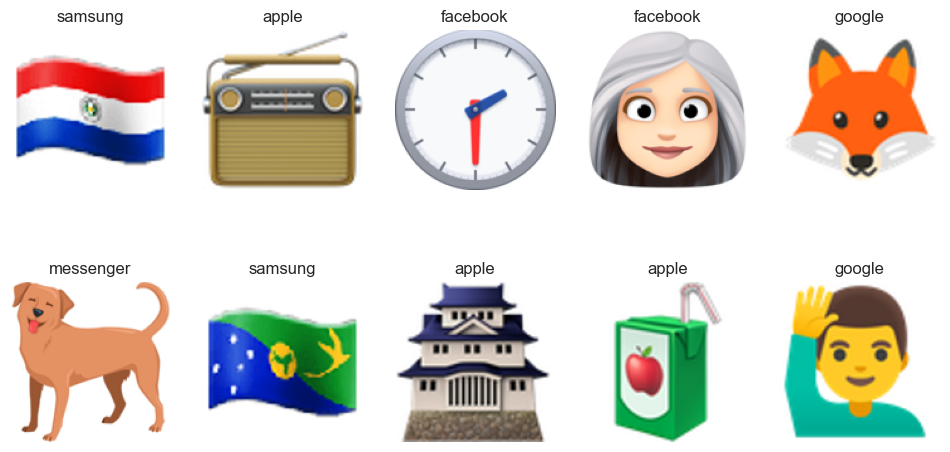

In [ ]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Dossiers (à adapter selon votre structure Kaggle/Local)
TRAIN_DIR = 'train/'
train_labels = pd.read_csv('train_labels.csv')

def load_and_preprocess_image(img_id, target_size=(128, 128)):
    # Formate l'ID (ex: 1 -> 00001.png)
    img_path = os.path.join(TRAIN_DIR, f"{str(img_id).zfill(5)}.png")
    
    # Ouverture de l'image
    img = Image.open(img_path).convert("RGBA")
    
    # REPARATION DES COULEURS : On crée un fond blanc
    # Cela évite les "erreurs de con" sur la transparence
    background = Image.new("RGBA", img.size, (255, 255, 255))
    composite = Image.alpha_composite(background, img).convert("RGB")
    
    # Redimensionnement standard pour tout le groupe
    return composite.resize(target_size)

# Visualisation propre de quelques exemples pour valider l'EDA
plt.figure(figsize=(12, 6))
for i in range(10):
    img_id = train_labels.iloc[i]['Id']
    label = train_labels.iloc[i]['Label']
    img = load_and_preprocess_image(img_id)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [ ]:
# Get class counts first
class_counts = train_labels['Label'].value_counts()

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Class Distribution - Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Platform', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 10})
axes[1].set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Most frequent class: {class_counts.idxmax()} ({class_counts.max()} samples)")
print(f"Least frequent class: {class_counts.idxmin()} ({class_counts.min()} samples)")

### 1.3 Image Data Analysis

In [ ]:
# Analyze image properties
train_dir = 'train'
test_dir = 'test'

# Get image files
train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)

print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

# Analyze image dimensions and properties
sample_images = np.random.choice(train_images, min(100, len(train_images)), replace=False)
image_sizes = []
image_modes = []
image_formats = []

for img_name in sample_images:
    img_path = os.path.join(train_dir, img_name)
    try:
        img = Image.open(img_path)
        image_sizes.append(img.size)
        image_modes.append(img.mode)
        image_formats.append(img.format)
    except Exception as e:
        print(f"Error loading {img_name}: {e}")

# Analyze dimensions
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

print(f"\nImage Dimensions Analysis (sample of {len(sample_images)} images):")
print(f"Width - Mean: {np.mean(widths):.2f}, Std: {np.std(widths):.2f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Height - Mean: {np.mean(heights):.2f}, Std: {np.std(heights):.2f}, Min: {np.min(heights)}, Max: {np.max(heights)}")

# Image modes
from collections import Counter
mode_counts = Counter(image_modes)
print(f"\nImage Modes: {dict(mode_counts)}")

# Image formats
format_counts = Counter(image_formats)
print(f"Image Formats: {dict(format_counts)}")

Number of training images: 9879
Number of test images: 9879

Image Dimensions Analysis (sample of 100 images):
Width - Mean: 128.80, Std: 73.49, Min: 72, Max: 240
Height - Mean: 128.76, Std: 73.52, Min: 68, Max: 240

Image Modes: {'P': 20, 'RGBA': 79, 'LA': 1}
Image Formats: {'PNG': 100}


### 1.4 Visualize Sample Images from Each Class

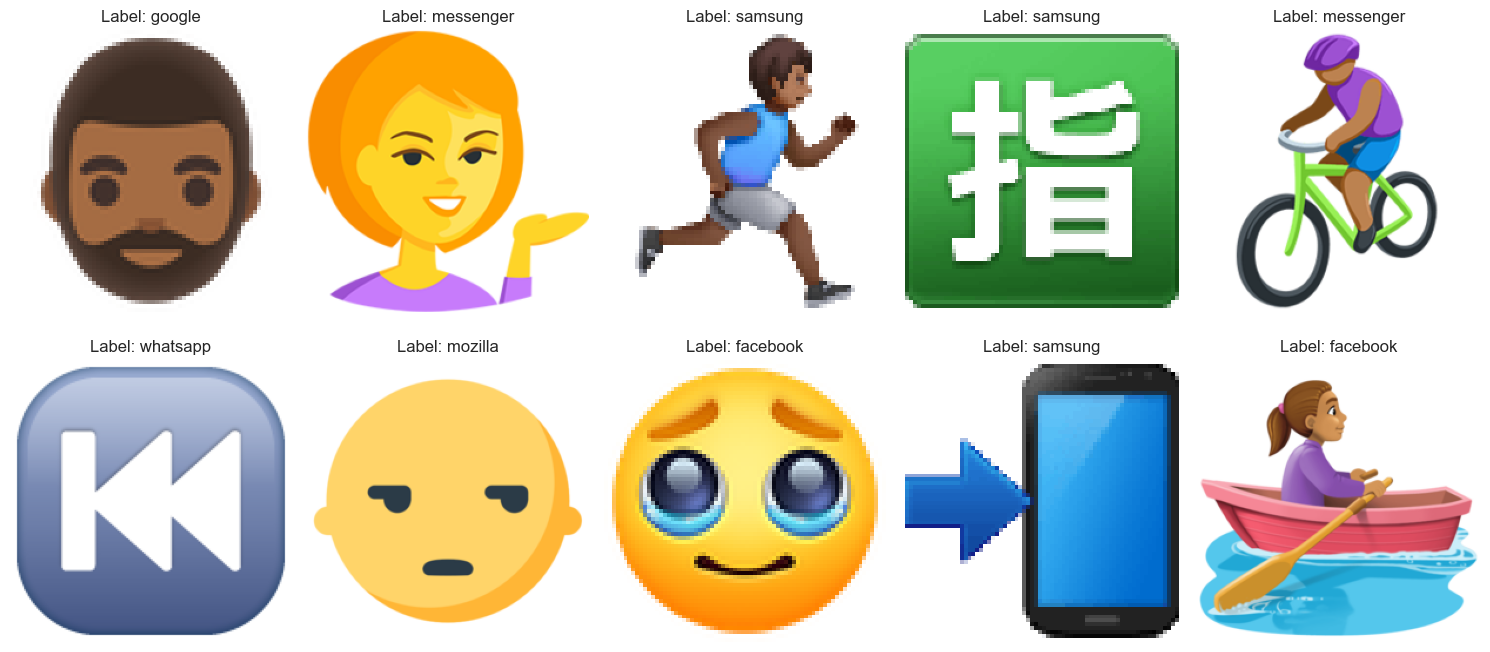

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def get_emoji_grid(df, n_rows=2, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7))
    # Take a random sample to ensure we see different classes
    sample_df = df.sample(n_rows * n_cols)
    
    for i, (idx, row) in enumerate(sample_df.iterrows()):
        ax = axes[i // n_cols, i % n_cols]
        # Ensure path matches: e.g., train/00001.png
        img_path = os.path.join('train', f"{str(row['Id']).zfill(5)}.png")
        
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGBA")
            # Composite on white background so they aren't "empty" or black
            bg = Image.new("RGBA", img.size, (255, 255, 255))
            img = Image.alpha_composite(bg, img).convert("RGB")
            
            ax.imshow(img)
            ax.set_title(f"Label: {row['Label']}")
        else:
            ax.set_title("File Not Found")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

get_emoji_grid(train_labels)

### 1.5 Image Color Distribution Analysis

In [ ]:
from collections import Counter

def analyze_dimensions(df):
    dims = []
    for img_id in df['Id'].head(500): # Check first 500 to be fast
        img_path = os.path.join('train', f"{str(img_id).zfill(5)}.png")
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                dims.append(img.size) # Returns (width, height)
    
    dim_counts = Counter(dims)
    print("Top Image Resolutions found:")
    for res, count in dim_counts.most_common(5):
        print(f"Resolution {res}: {count} images")

analyze_dimensions(train_labels)

Top Image Resolutions found:
Resolution (72, 72): 296 images
Resolution (240, 240): 123 images
Resolution (160, 160): 76 images
Resolution (72, 68): 4 images
Resolution (64, 64): 1 images


Analyzing visual styles (Brightness, Saturation, Contrast)...


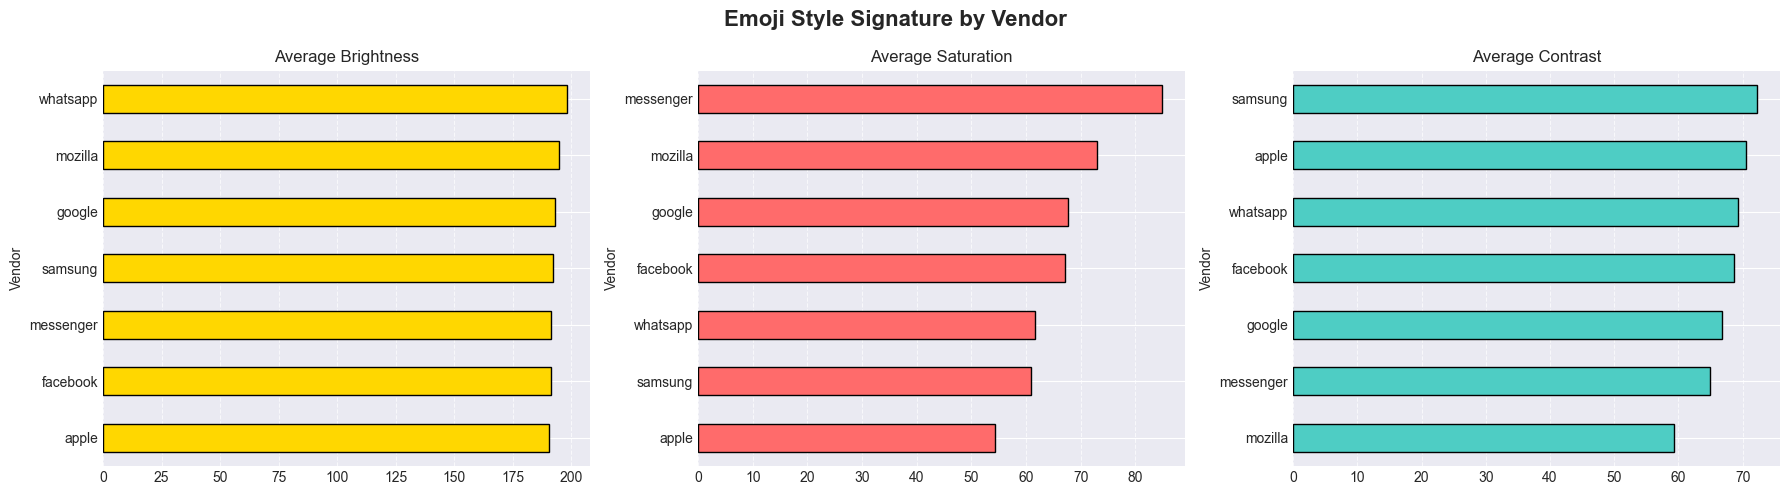

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageStat

def analyze_visual_styles(df, train_dir='train', num_samples=50):
    classes = df['Label'].unique()
    style_results = []

    print("Analyzing visual styles (Brightness, Saturation, Contrast)...")
    
    for label in classes:
        # Get samples for this specific brand
        class_samples = df[df['Label'] == label].sample(min(num_samples, len(df[df['Label'] == label])))
        
        b_list, s_list, c_list = [], [], []
        
        for _, row in class_samples.iterrows():
            # FIX 1: The zfill(5) ensures we find '00001.png' instead of '1.png'
            img_path = os.path.join(train_dir, f"{str(row['Id']).zfill(5)}.png")
            
            if os.path.exists(img_path):
                img = Image.open(img_path).convert("RGBA")
                
                # FIX 2: Composite on white so transparency doesn't count as "zero brightness"
                bg = Image.new("RGBA", img.size, (255, 255, 255))
                img_rgb = Image.alpha_composite(bg, img).convert("RGB")
                
                # Calculate metrics
                stat = ImageStat.Stat(img_rgb)
                
                # 1. Brightness: Average of the R,G,B means
                brightness = np.mean(stat.mean) 
                
                # 2. Saturation: We convert to HSV to get true saturation levels
                hsv_img = img_rgb.convert("HSV")
                hsv_stat = ImageStat.Stat(hsv_img)
                saturation = hsv_stat.mean[1] # The 'S' channel
                
                # 3. Contrast: Standard deviation of the pixels (RMS Contrast)
                contrast = np.mean(stat.stddev)
                
                b_list.append(brightness)
                s_list.append(saturation)
                c_list.append(contrast)
        
        style_results.append({
            'Vendor': label,
            'Brightness': np.mean(b_list),
            'Saturation': np.mean(s_list),
            'Contrast': np.mean(c_list)
        })

    return pd.DataFrame(style_results).set_index('Vendor')

# Run the analysis
style_df = analyze_visual_styles(train_labels)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['Brightness', 'Saturation', 'Contrast']
colors = ['#FFD700', '#FF6B6B', '#4ECDC4']

for i, metric in enumerate(metrics):
    style_df[metric].sort_values().plot(kind='barh', ax=axes[i], color=colors[i], edgecolor='black')
    axes[i].set_title(f'Average {metric}')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle('Emoji Style Signature by Vendor', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.6 Data Quality Checks  <--- Issue here is that the image numbers go from 00001 to 09879 not 1 to 9879 (so it says that everything is missing lol)

In [ ]:
# Check if all labeled images exist
missing_images = []
for idx, row in train_labels.iterrows():
    # FIX: Use zfill(5) to format ID as 00001 instead of 1
    img_path = os.path.join(train_dir, f"{str(row['Id']).zfill(5)}.png")
    if not os.path.exists(img_path):
        missing_images.append(row['Id'])

print(f"Missing images: {len(missing_images)}")
if missing_images:
    print("Missing IDs:", missing_images[:10], "..." if len(missing_images) > 10 else "")

# Check for unlabeled images in train folder
labeled_ids = set(str(id).zfill(5) for id in train_labels['Id'].values)
image_ids = set([img.replace('.png', '') for img in train_images if img.endswith('.png')])
unlabeled = image_ids - labeled_ids

print(f"\nUnlabeled images in train folder: {len(unlabeled)}")
if unlabeled:
    print("Sample unlabeled:", list(unlabeled)[:10])

### 1.7 EDA Summary and Insights

In [ ]:
import cv2
import numpy as np

def extract_emoji_features(img_id, train_dir='train'):
    img_path = os.path.join(train_dir, f"{str(img_id).zfill(5)}.png")
    if not os.path.exists(img_path): return None
    
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None: return None
    
    # 1. Handle Alpha Channel for Color Features
    if img.shape[2] == 4:
        alpha = img[:, :, 3] / 255.0
        bg = np.ones_like(img[:, :, :3]) * 255
        for c in range(3):
            img[:, :, c] = img[:, :, c] * alpha + bg[:, :, c] * (1 - alpha)
    img = img[:, :, :3] # Keep only RGB
    
    # --- FEATURE 1: Color Means ---
    mean_color = cv2.mean(img)[:3] # Returns (B, G, R)
    
    # --- FEATURE 2: Edge Density (Canny) ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
    
    # --- FEATURE 3: Contrast ---
    contrast = gray.std()
    
    return {
        'Id': img_id,
        'mean_b': mean_color[0],
        'mean_g': mean_color[1],
        'mean_r': mean_color[2],
        'edge_density': edge_density,
        'contrast': contrast
    }


In [ ]:
features_list = [extract_emoji_features(id) for id in train_labels['Id'].head(100)]

feature_df = pd.DataFrame([f for f in features_list if f is not None])

# We merge feature_df with the original train_labels to get the 'Label' column
viz_df = feature_df.merge(train_labels[['Id', 'Label']], on='Id')

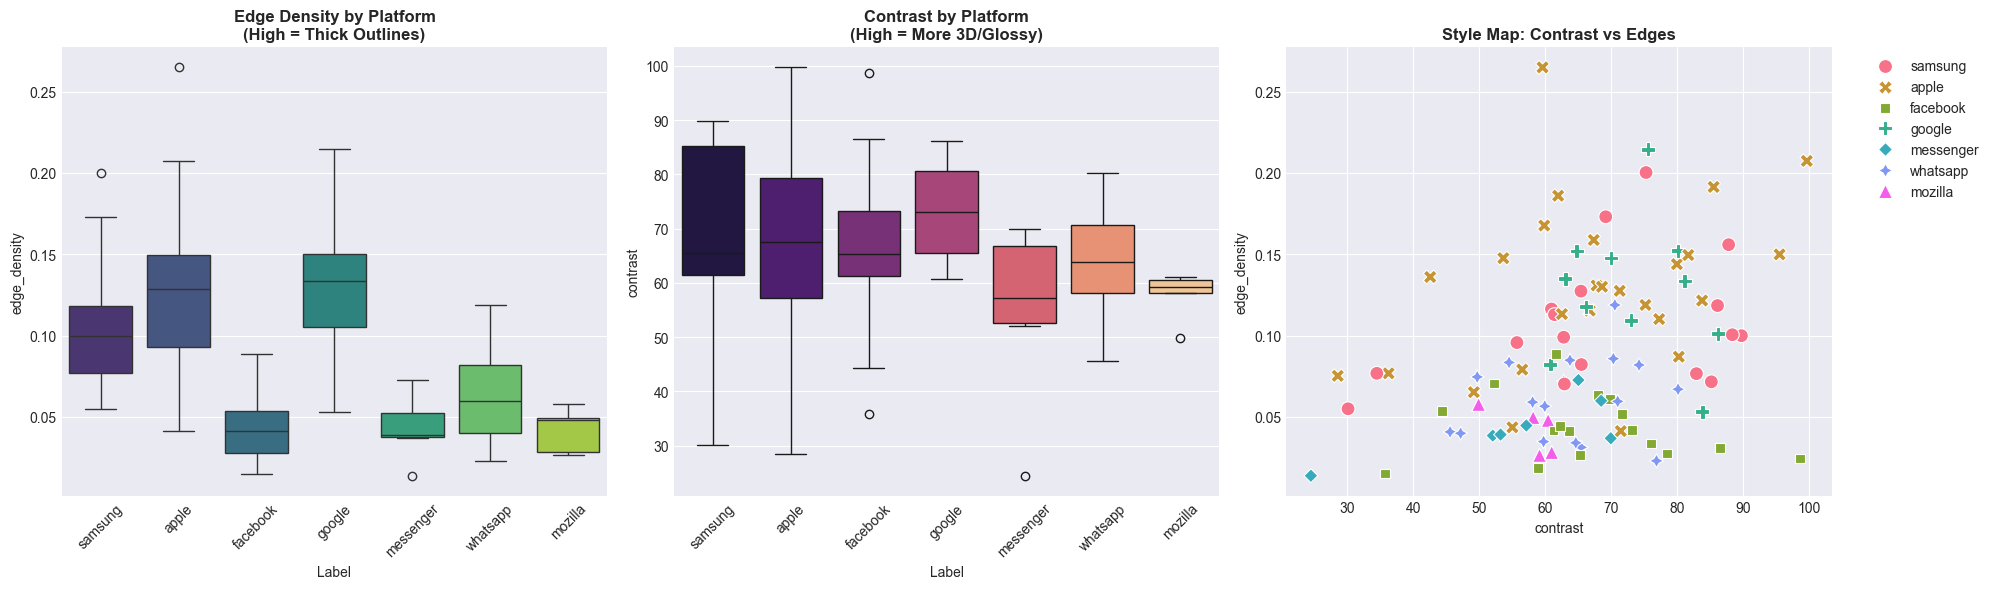

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Edge Density (Outline Thickness)
sns.boxplot(data=viz_df, x='Label', y='edge_density', ax=axes[0], palette='viridis')
axes[0].set_title('Edge Density by Platform\n(High = Thick Outlines)', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Contrast (Flat vs 3D)
sns.boxplot(data=viz_df, x='Label', y='contrast', ax=axes[1], palette='magma')
axes[1].set_title('Contrast by Platform\n(High = More 3D/Glossy)', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Color Scatter (The "Style Map")
# This plots Contrast vs Edge Density to see if classes cluster together
sns.scatterplot(data=viz_df, x='contrast', y='edge_density', hue='Label', style='Label', s=100, ax=axes[2])
axes[2].set_title('Style Map: Contrast vs Edges', fontweight='bold')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import os

def extract_emoji_features(img_id, train_dir='train'):
    img_path = os.path.join(train_dir, f"{str(img_id).zfill(5)}.png")
    if not os.path.exists(img_path): return None
    
    # Load image exactly as it is (including Alpha if it exists)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None: return None
    
    # FIX: Handle Grayscale images (images with only 2 dimensions)
    if len(img.shape) == 2:
        # Convert Grayscale to BGR so it has 3 channels
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # 1. Handle Alpha Channel (4 channels)
    if img.shape[2] == 4:
        alpha = img[:, :, 3] / 255.0
        bg = np.ones_like(img[:, :, :3], dtype=np.float32) * 255
        img_rgb = img[:, :, :3].astype(np.float32)
        
        for c in range(3):
            img_rgb[:, :, c] = img_rgb[:, :, c] * alpha + bg[:, :, c] * (1 - alpha)
        
        img = img_rgb.astype(np.uint8)
    else:
        # If it's already 3 channels, just make sure it's RGB
        img = img[:, :, :3]
    
    # --- Now all images are guaranteed to have 3 channels (uint8) ---
    
    # FEATURE 1: Color Means
    mean_color = cv2.mean(img)[:3] 
    
    # FEATURE 2: Edge Density
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
    
    # FEATURE 3: Contrast
    contrast = gray.std()
    
    return {
        'Id': img_id,
        'mean_b': mean_color[0],
        'mean_g': mean_color[1],
        'mean_r': mean_color[2],
        'edge_density': edge_density,
        'contrast': contrast
    }

In [ ]:
from tqdm import tqdm
import pandas as pd

all_features = []
print("Extracting features (this will take a moment)...")

for img_id in tqdm(train_labels['Id']):
    feat = extract_emoji_features(img_id) # Using the FIXED function from before
    if feat is not None:
        all_features.append(feat)

# Create DataFrame and ensure 'Id' is the index for easy merging
full_feature_df = pd.DataFrame(all_features).set_index('Id')

# Align the labels: only keep labels for images we successfully processed
y = train_labels.set_index('Id').loc[full_feature_df.index]['Label']
X = full_feature_df

print(f"\nSuccessfully processed {len(X)} images.")

Extracting features (this will take a moment)...


100%|██████████| 9879/9879 [02:05<00:00, 78.52it/s] 


Successfully processed 9879 images.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Encode text labels to numbers (0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 3. Train
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred = rf_model.predict(X_val)
print("\nSTYLE CLASSIFIER ACCURACY:")
print(classification_report(y_val, y_pred, target_names=le.classes_))


STYLE CLASSIFIER ACCURACY:
              precision    recall  f1-score   support

       apple       0.45      0.46      0.45       385
    facebook       0.53      0.69      0.60       333
      google       0.46      0.50      0.48       376
   messenger       0.78      0.25      0.38       116
     mozilla       0.79      0.38      0.51        79
     samsung       0.45      0.43      0.44       358
    whatsapp       0.49      0.49      0.49       329

    accuracy                           0.49      1976
   macro avg       0.56      0.46      0.48      1976
weighted avg       0.50      0.49      0.48      1976



### 1.8 Detailed Image Size and Aspect Ratio Analysis by Label

In [ ]:
# Analyze all images for detailed size analysis
print("Analyzing all images for size and aspect ratio...")
image_properties = []

for idx, row in train_labels.iterrows():
    img_id = row['Id']
    label = row['Label']
    img_path = os.path.join('train', f"{str(img_id).zfill(5)}.png")
    
    if os.path.exists(img_path):
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                aspect_ratio = width / height if height > 0 else 0
                image_properties.append({
                    'Id': img_id,
                    'Label': label,
                    'Width': width,
                    'Height': height,
                    'AspectRatio': aspect_ratio,
                    'PixelCount': width * height
                })
        except Exception as e:
            pass

image_props_df = pd.DataFrame(image_properties)
print(f"Analyzed {len(image_props_df)} images")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Width distribution by label
for label in image_props_df['Label'].unique():
    label_data = image_props_df[image_props_df['Label'] == label]
    axes[0, 0].hist(label_data['Width'], alpha=0.6, label=label, bins=30)
axes[0, 0].set_xlabel('Width (pixels)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Width Distribution by Label', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution by label
for label in image_props_df['Label'].unique():
    label_data = image_props_df[image_props_df['Label'] == label]
    axes[0, 1].hist(label_data['Height'], alpha=0.6, label=label, bins=30)
axes[0, 1].set_xlabel('Height (pixels)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Height Distribution by Label', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution by label
for label in image_props_df['Label'].unique():
    label_data = image_props_df[image_props_df['Label'] == label]
    axes[1, 0].hist(label_data['AspectRatio'], alpha=0.6, label=label, bins=30)
axes[1, 0].set_xlabel('Aspect Ratio (width/height)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Aspect Ratio Distribution by Label', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Box plot: Aspect ratio by label
image_props_df.boxplot(column='AspectRatio', by='Label', ax=axes[1, 1])
axes[1, 1].set_xlabel('Label', fontsize=12)
axes[1, 1].set_ylabel('Aspect Ratio', fontsize=12)
axes[1, 1].set_title('Aspect Ratio by Label (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("Image Size Statistics by Label")
print("="*70)
size_stats = image_props_df.groupby('Label')[['Width', 'Height', 'AspectRatio', 'PixelCount']].agg(['mean', 'std', 'min', 'max'])
print(size_stats)